### Invariant measures with small noise
##### - Code by Dan Vicente Ihanus
--------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
import scipy as sp
from mpl_toolkits import mplot3d
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd


rcParams["figure.dpi"] = 400
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

def turn_off_pane_fills(ax):
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

directory = 'plots/'
datadir = 'projekt-data/data/'

In [2]:
def dynamics(X, dt, µ, δ, ε):
    x, y, z = X
    dW = np.random.normal(loc=0, scale=np.sqrt(dt))
    dx = (µ*x - y**2 + 2*z**2 - δ*z)*dt
    dy = y*(x-1)*dt + np.sqrt(2)*ε*dW
    dz = (µ*z + δ*x - 2*x*z)*dt
    dX = np.array([dx, dy, dz])
    return dX

In [3]:
'''Model parameters'''

X0 = np.array([0.5, 0.02, 0.5])
X0_2 = np.array([0.5, 0.0001, 0.5])
X0_3 = np.array([-0.5, -0.2, 0.3])
N = 1000000              
L = 10
dt = 0.001
X = np.zeros((N+1, 3))
X[0, :] = X0_3
µ, δ = 0.01, 1.5
ε = µ*0.001


-------------------------------------------------------------------------------------------------
## Simulation of the Random dynamical system
-------------------------------------------------------------------------------------------------


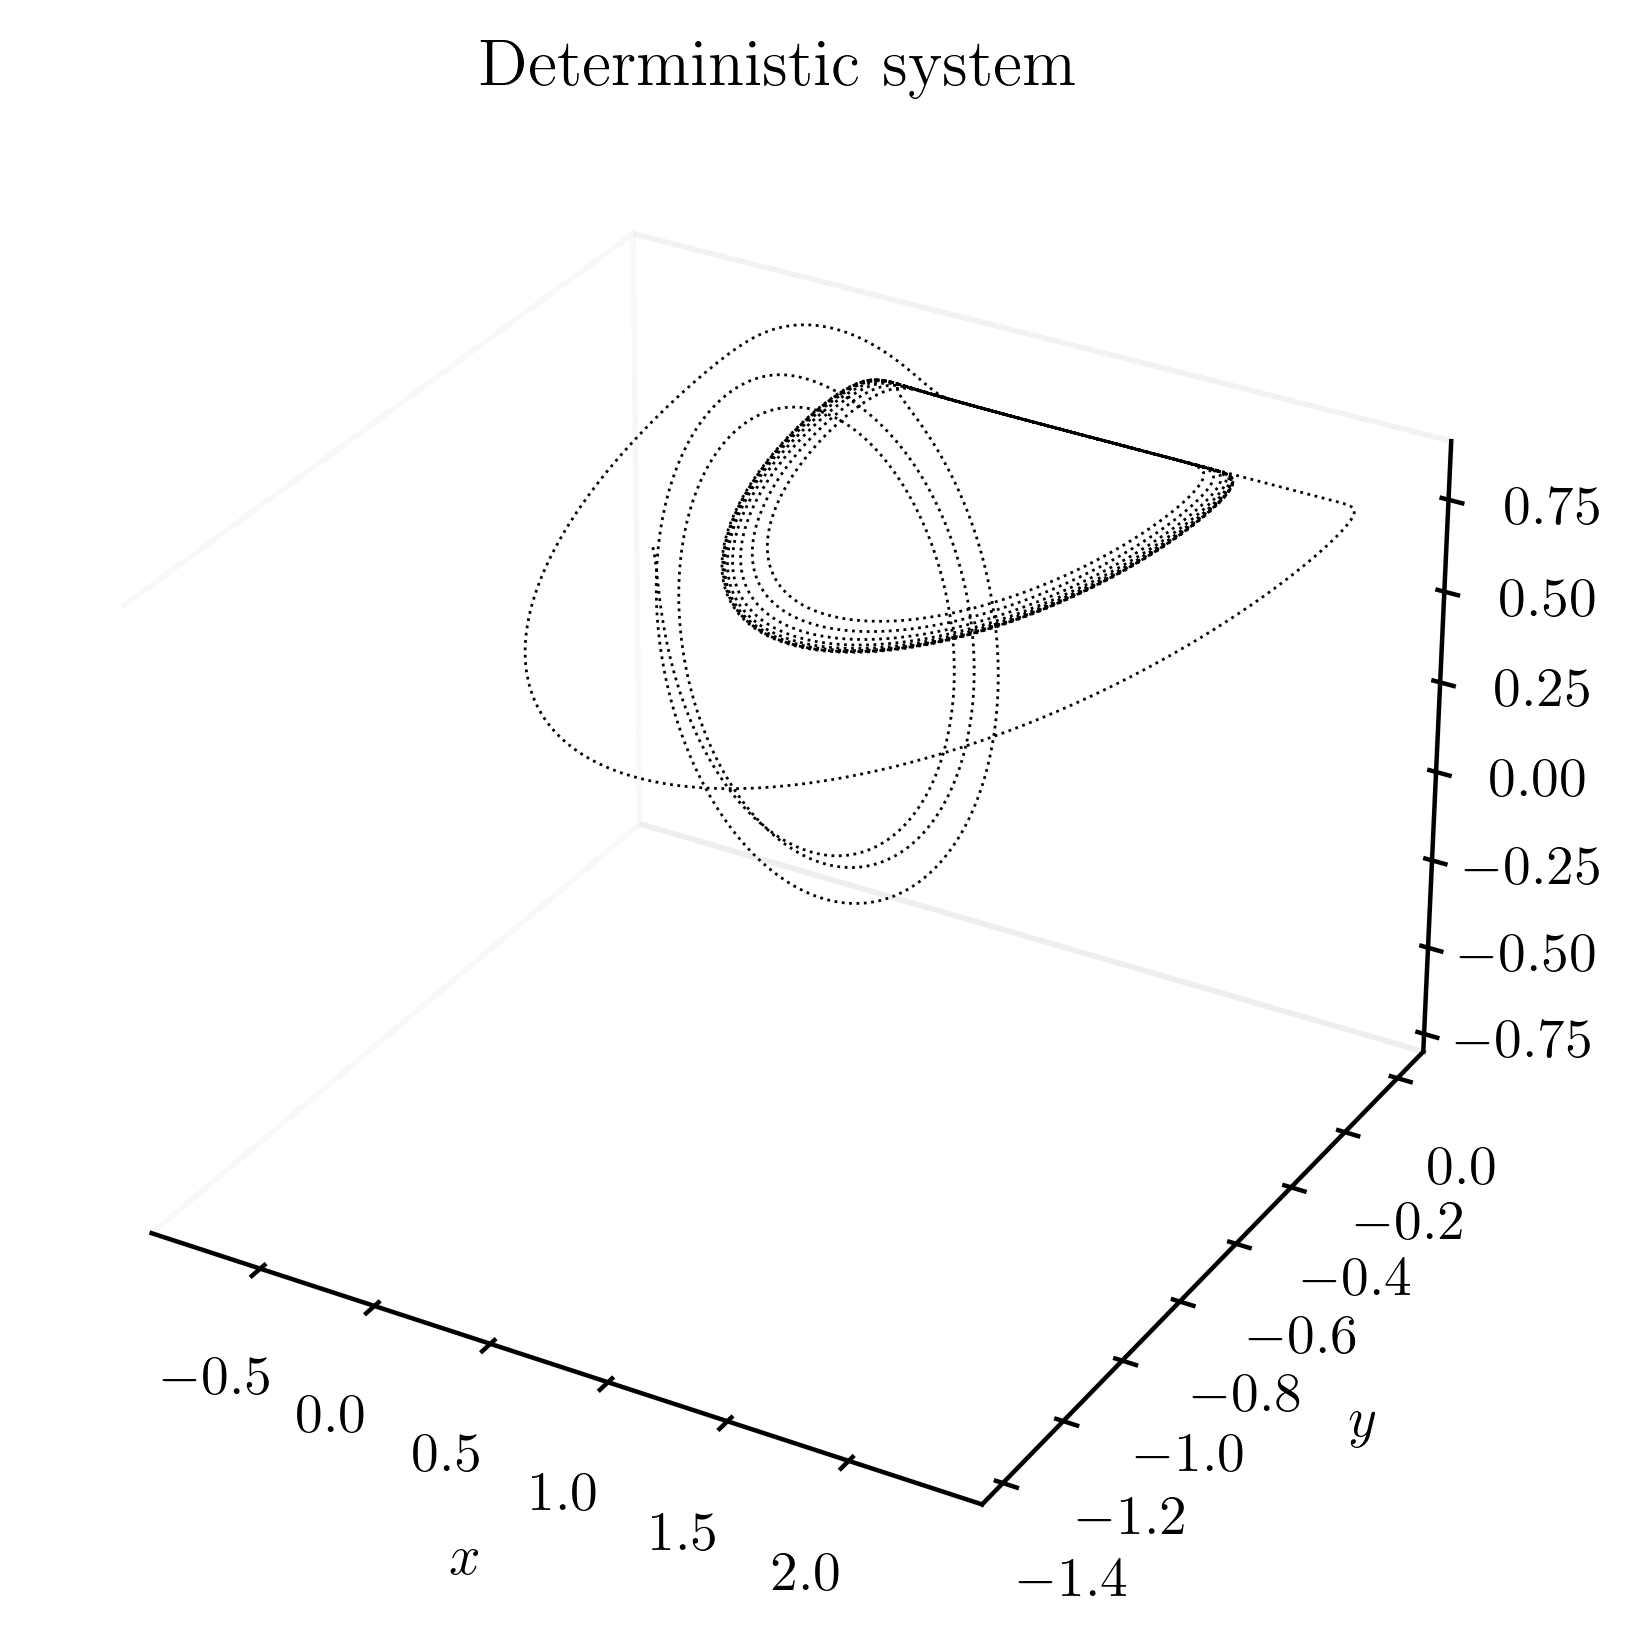

In [4]:
'''Simulation of deterministic system'''
for i in range(N):
    X[i+1, :] = X[i, :] + dynamics(X[i-1, :], dt, µ, δ, 0)
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(X[:, 0], X[:, 1], X[:, 2], color='black', linewidth=0.5, linestyle='dotted')
ax.grid(False)
turn_off_pane_fills(ax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Deterministic system')
fig.savefig(directory + 'deterministic_system.pdf', bbox_inches='tight')


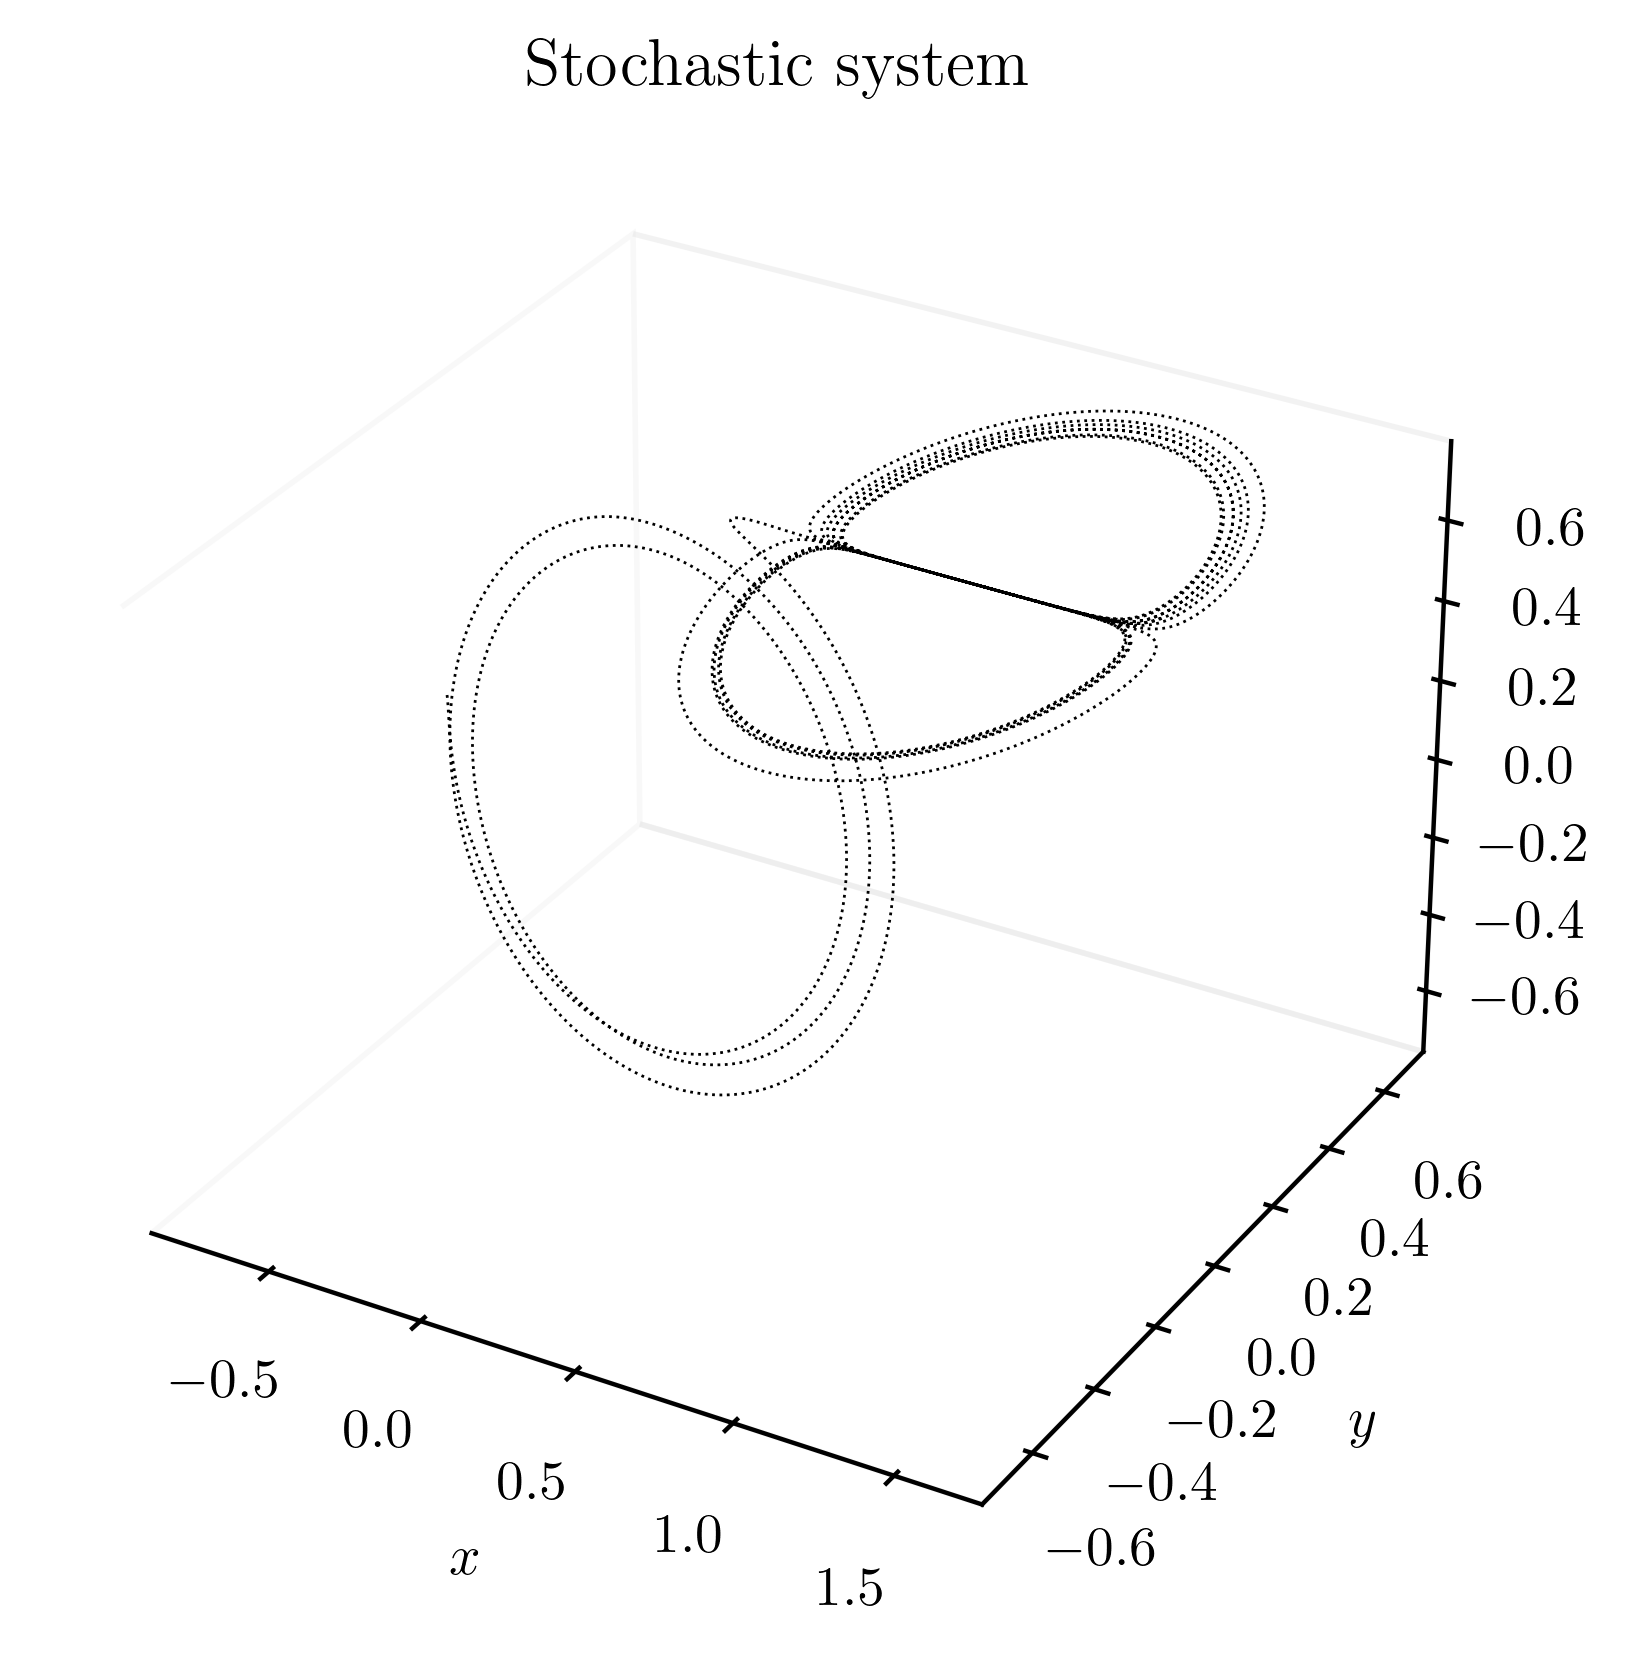

In [5]:
'''Simulation of stochastic system'''

X_stoch = np.zeros((N+1, 3))
X_stoch[0, :] = X0_3

for i in range(N):
    X_stoch[i+1, :] = X_stoch[i, :] + dynamics(X_stoch[i, :], dt, µ, δ, ε)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot3D(X_stoch[:, 0], X_stoch[:, 1], X_stoch[:, 2], color='black', linewidth=0.5, linestyle='dotted')
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_zlabel('$z$')
ax2.set_title('Stochastic system')
ax2.grid(False)
turn_off_pane_fills(ax2)
fig2.savefig(directory + 'stochastic_system.pdf', bbox_inches='tight')



-------------------------------------------------------------------------------------------------

## Generating data and computing PCA
#### Goal: Try to find the plane z = $\delta /2$ as in the paper
(Note that the first cell generates data from the dynamics and takes a huge amount of time)

-------------------------------------------------------------------------------------------------

In [ ]:
''' Generate Stochastic data for estimating the invariant density'''
'''NOTE: TAKES A LONG TIME'''

for i in range(500):
    X = np.zeros((N+1, 3))
    X0 = np.random.uniform(low=-1.0, high=1.0, size=3)
    X[0, :] = X0
    for j in range(N):
        X[j+1, :] = X[j, :] + dynamics(X[j, :], dt, µ, δ, ε)
    np.save(datadir + f'X_{i}.npy', X)

In [8]:
''' Load the generated data '''

data_matrix = np.zeros((500, N, 3))
for j in range(500):
    data_matrix[j, :, :] = np.load(datadir+f'X_{j}.npy')

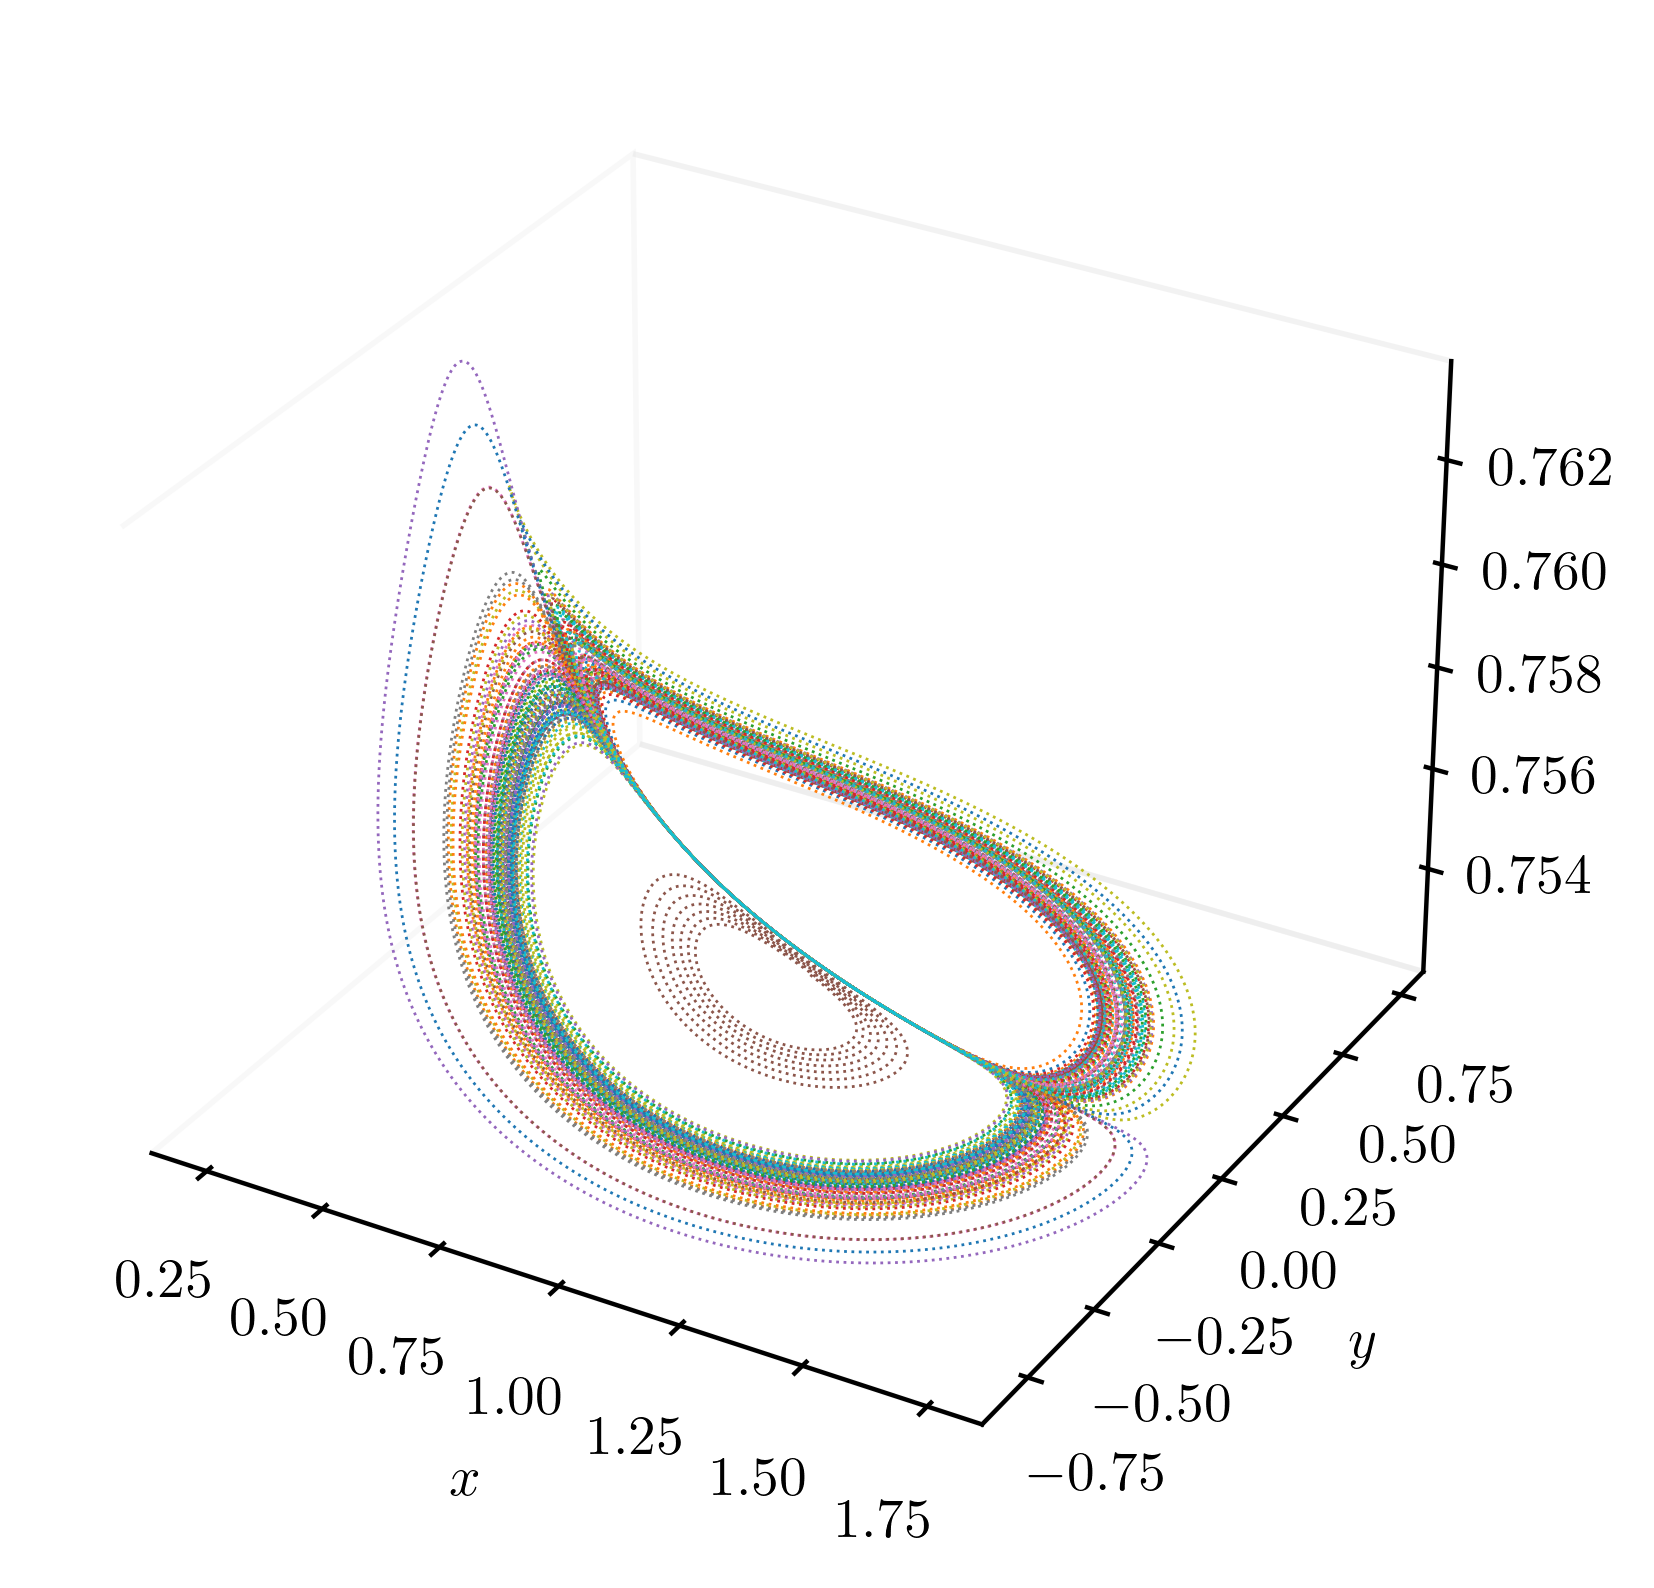

In [9]:
''' Test the data '''

fig_test = plt.figure()
ax_test = fig_test.add_subplot(111, projection='3d')
ax_test.set_xlabel('$x$'); ax_test.set_ylabel('$y$')
turn_off_pane_fills(ax_test)
ax_test.grid(False)

for i in range(50):
    ax_test.plot3D(data_matrix[i, 700000:,0], data_matrix[i,700000:,1], data_matrix[i,700000:,2], linewidth=0.5, ls=':')


In [10]:
''' Truncate data at end '''
K = 990000
truncated_matrix = data_matrix[:, K:, :]

In [11]:
''' Reshape data and create a dataframe for the PCA '''

reshaped_data = np.reshape(truncated_matrix, 
                           (len(truncated_matrix[:,0,0])*len(truncated_matrix[0,:,0]), 3))
data = pd.DataFrame(reshaped_data, columns=['x', 'y', 'z'])
reduced_data = data[['x', 'y']].copy()


In [12]:
''' Compute PCA '''

norm_data = StandardScaler().fit_transform(data)
pca = PCA(n_components=2)
p_components = pca.fit_transform(norm_data)

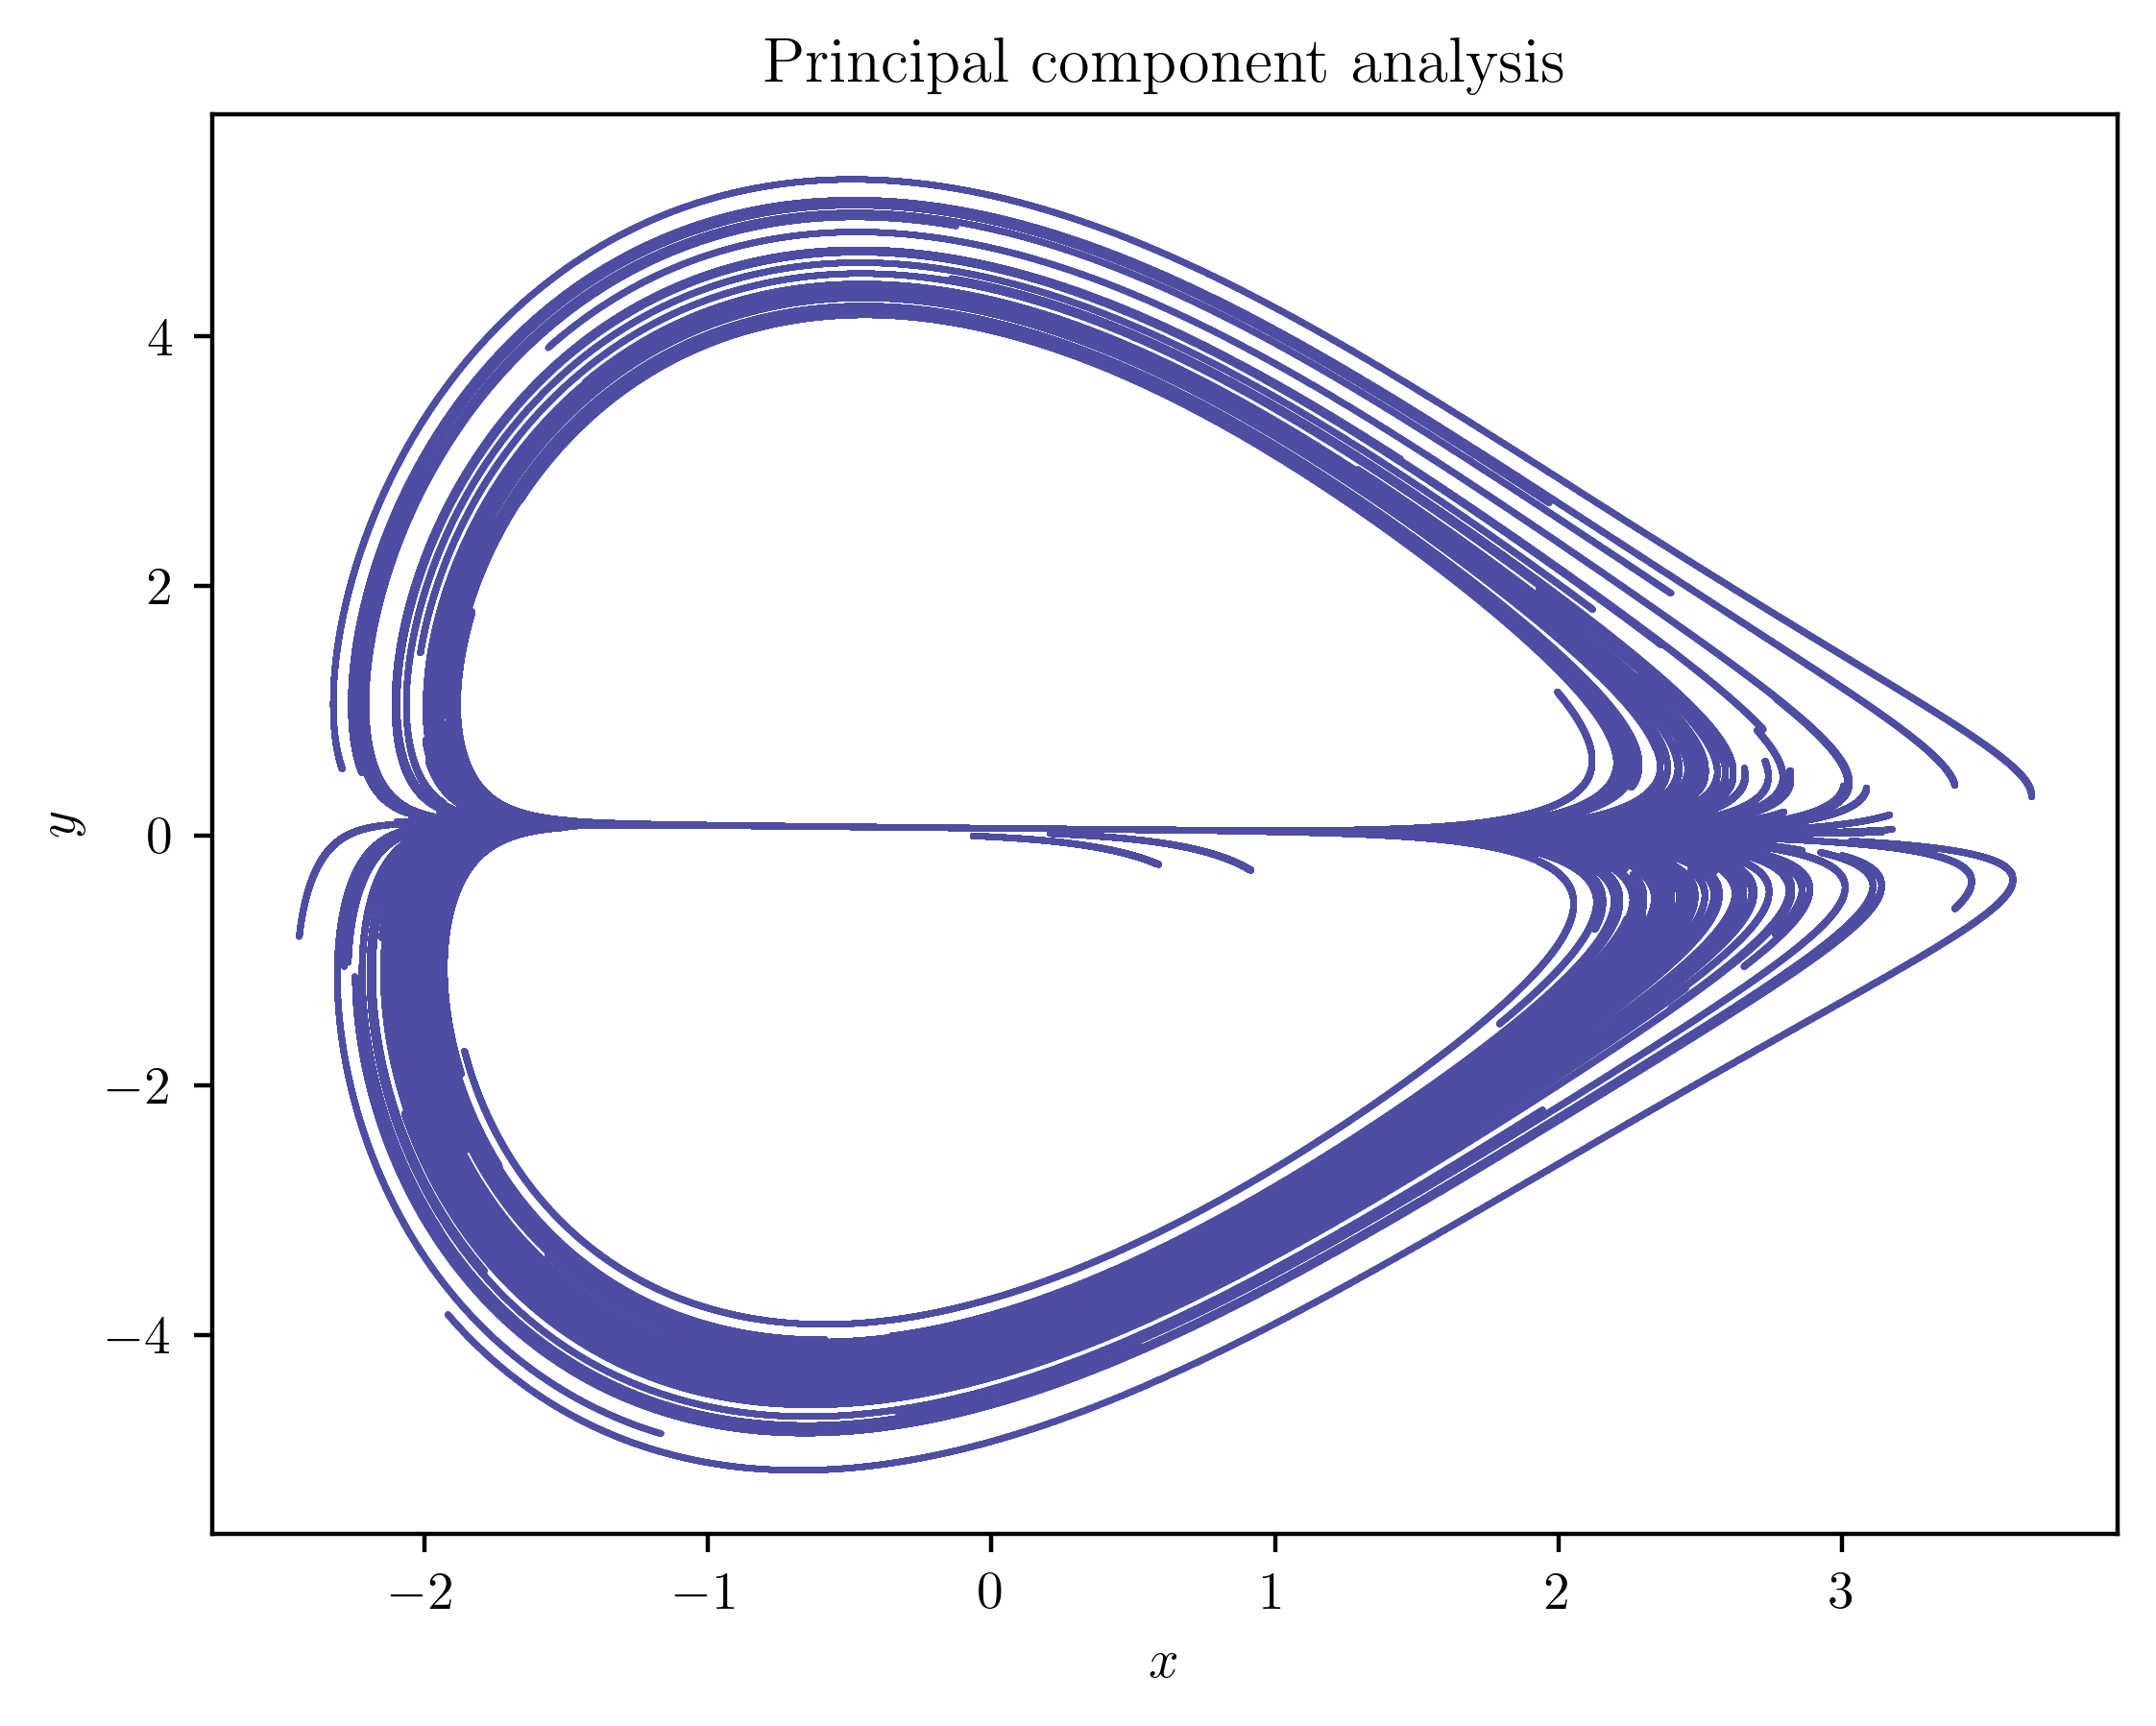

In [13]:
''' Plot result from PCA '''

fig_PCA, ax_PCA = plt.subplots()
ax_PCA.set_xlabel('$x$')
ax_PCA.set_ylabel('$y$')
ax_PCA.set_title('Principal component analysis')
ax_PCA.scatter(p_components[:, 0], p_components[:, 1], color='#4D4DA2', s=0.1, marker='.')
fig_PCA.savefig('PCA_scatter.pdf', bbox_inches='tight')

#### Conclusions from PCA:
PCA and plots seem to suggest that the data is not distributed on the plane  $z = \delta / 2 $ asymptotically. It actually seems like the data is located in some other manifold (plane) in $\mathbb{R}^3$. Might possibly need to generate longer time series, for better results.

-------------------------------------------------------------------------------------------------

## Computing KDE of the truncated time series
#### Goal: Try to estimate the invariant density 

-------------------------------------------------------------------------------------------------

In [17]:
'''Compute KDE '''

random_indices =  np.random.randint(low=0, high=len(reshaped_data[:,0]), size = 100000)
reduced = reduced_data.to_numpy()
selected = reduced[random_indices, :]
selected = selected.T
kde = sp.stats.gaussian_kde(selected)
kde_density = kde(selected)